# LDA Topic Modeling for Reviews

## Andy Karr 

## 0. Introduction

This report investigates 12,415 reviews taken from 2017-2021 and segments them into topics using LDA Topic Modeling. 

The purpose of this investigation is to find 3 to 7 topics (the best number of topics will be statistically investigated), to highlight what those topics are and to segment new data into these topics.

It was found from using coherence score analysis that 7 topics gives the highest coherence score and therefore it is most optimal to use 7 topics.

Some stopwords were removed from the cleaning of the text to allow for terms such as "not good" - normally words like "not" are removed from texts as this is a stop word but we want to retain the sentiment of "not good" being negative.

The report is split into the following sections.

1. Preparation of the data.
2. Building the model and exploring the created topics.
3. Visualisation of the model.
4. Using new reviews and assigning them to our created topics. I used 2 mock reviews for this as a demonstration and left instructions how to assign topics to new reviews further below in section 4.

## 1. Data Prep

### 1.1 Load libraries

In [450]:
#load libraries
import nltk
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

### 1.2 Glance at the raw data

In [451]:
import pandas as pd
df = pd.read_csv('data/final_df.csv')
#print(df.to_string())
df.head()

,feedback_created_at,final_msg_join,feedback_message
0,2017-11-10 08:00:18,top,Top
1,2017-11-10 08:51:40,blinker defect break delay,"blinker defect, break work delayed"
2,2017-11-10 08:43:30,app really well,App did not work really well
3,2017-11-10 09:51:10,ending ride first attempt start app try,Ending ride didn’t work at first attempt. I had to restart the app and try again
4,2017-11-10 10:04:59,battery keep change level dramatically,Battery kept changing its level dramatically.


### 1.3 Frequency of reviews for each year¶

C:\Users\T430\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<AxesSubplot:xlabel='year'>

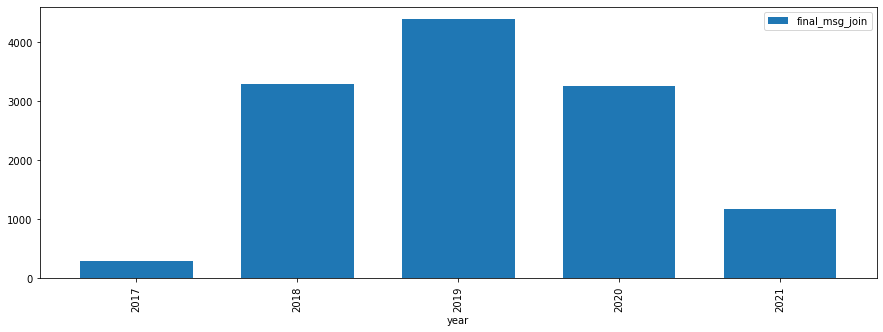

In [452]:
df['Date']= pd.to_datetime(df['feedback_created_at'])
df['final_msg_join'] = df['final_msg_join'].astype(str)
df['year'] = pd.DatetimeIndex(df['Date']).year

from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords


tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
vectors_text = tfidf_text.fit_transform(df['final_msg_join'])
vectors_text.shape

%matplotlib inline
df.groupby('year').agg({'final_msg_join': 'count'}).plot.bar(figsize=(15,5),width=0.7)


### 1.4 Data prep

The data is prepared by 
1. Taking out stopwords.
2. Tokenisation (splitting the reviews into individual words).
3. Taking bigrams and trigrams.

Some notes to make here are for stop words, some negative words such as "not" are normally taken out but for this analysis I believe it's important. For example, there is a review that said "not good". Normally, the stop word would take out the "not" part and leave out the "good". This means that the message would be interpreted as positive but it's actually not. For that reason I used a manual list of stop words and generally left in words like "not" or "couldn't" as I believe this is important for the analysis.

Equally, I included bigrams and trigrams. These are simple things. The default behaviour of this modeling is to use single words and use them for the analysis, for example if a review said "the bike is not good", each word, "the", "bike", "is", "not", "good" are used individually in the analysis (actually "the" and "is" are stop words and are removed). I have used bigrams which means we group 2 words together, therefore "not good" will be taken together as a word in the analysis. This captures the sentiment of it being bad. Trigrams work in a similar way but with 3 words, for example "not working well" will be grouped together and used in the model. 

In [453]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = ['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'out',
 'under',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'both',
 'each',
 'few',
 'other',
 'some',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 'should',
 "should've",
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",]


#animals.remove('rabbit')


#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.feedback_message.values.tolist()
data_words = list(sent_to_words(data))
#print(data_words[:3])


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]



## 2. LDA Analysis

### 2.1 Run the model and look at the words that contribute most to each topic

The below output shows for each topic the words that contribute the most to that topic, for example "0" shows "not" contributing most to topic 0, "break" contributing most to topic 1, and so on. This will be presented clearer later on in the report.

In [454]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())



[(0,
  '0.182*"not" + 0.133*"helmet" + 0.046*"work" + 0.032*"could" + 0.030*"well" '
  '+ 0.029*"close" + 0.022*"helmet_case" + 0.020*"bit" + 0.020*"broken" + '
  '0.019*"properly"'),
 (1,
  '0.090*"break" + 0.072*"battery" + 0.061*"take" + 0.037*"drive" + '
  '0.034*"front" + 0.033*"one" + 0.027*"button" + 0.027*"bad" + 0.024*"loose" '
  '+ 0.019*"stand"'),
 (2,
  '0.066*"ride" + 0.061*"app" + 0.038*"start" + 0.037*"slow" + 0.033*"try" + '
  '0.030*"more" + 0.024*"up" + 0.022*"minute" + 0.021*"would" + 0.018*"love"'),
 (3,
  '0.079*"scooter" + 0.064*"in" + 0.063*"on" + 0.040*"open" + 0.031*"no" + '
  '0.029*"time" + 0.025*"stop" + 0.024*"get" + 0.024*"back" + 0.023*"need"'),
 (4,
  '0.071*"moto" + 0.054*"yego" + 0.053*"park" + 0.041*"brake" + 0.032*"move" + '
  '0.030*"trip" + 0.029*"right" + 0.028*"front_wheel" + 0.026*"trunk" + '
  '0.026*"speed"'),
 (5,
  '0.106*"nt" + 0.052*"leave" + 0.035*"case" + 0.034*"dangerous" + '
  '0.032*"want" + 0.029*"picture" + 0.025*"turn" + 0.024*"cou

### 2.2a Coherence score check
The following code chunk gives us the coherence score for 7 topics. We get a score of 0.39, which tells us if 7 topics is a good number of topics. This is a relatively low score. This can be explained by the fact there are many reviews with low amount of words, sometimes single words such as "top". With more words in each review, this score would increase. Given this fact, a coherence of 0.39 is acceptable. 

In [455]:
from gensim.models.coherencemodel import CoherenceModel

lda_gensim_para_coherence = CoherenceModel(model=lda_model,
    texts=data_ready, dictionary=id2word, coherence='c_v')
lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()
print(lda_gensim_para_coherence_score)

0.38774406026440883


### 2.2b Check what is the best number of topics

The following code gets the coherence score of each lda model run using topics in the range 3 to 7 to find which is the most optimal amount of topics. A high coherence score means a good number of topics. In this final report the code isn't run because it takes a long time and therefore I commented it out. 

However, I did run this code previously and found 7 was the best number of topics. When I ran it the pre-processing of the data wasn't as good so we see a lower score than above for 7 topics, but 7 topics would still come out as the winner after these new pre-processing applications.

The image of this plot follows. It shows 7 topics has the highest coherence score and therefore we use 7 topics.

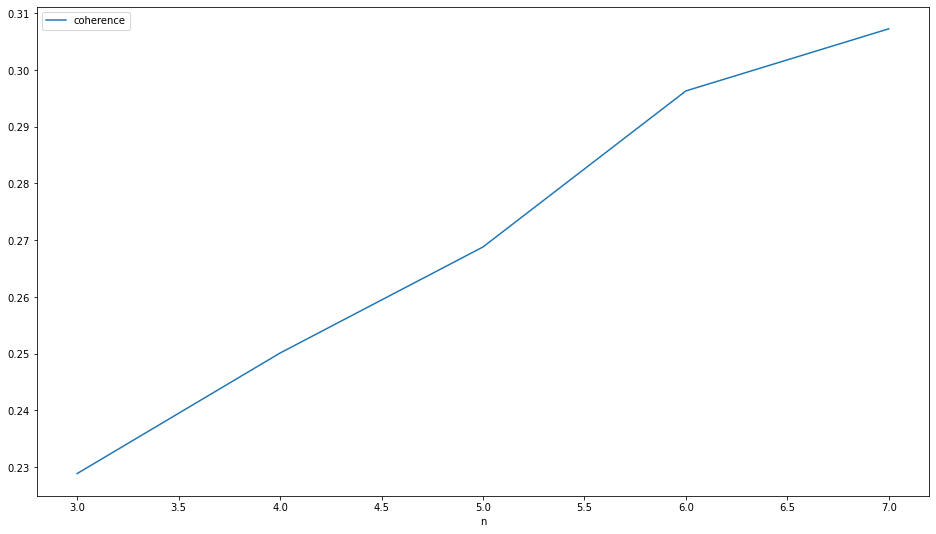

In [456]:
from IPython.display import Image
Image("coherence.png")

In [457]:

# from gensim.models.ldamulticore import LdaMulticore
# lda_para_model_n = []
# for n in range(3, 8):
#     lda_model_c = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=2000, eta='auto', iterations=400, num_topics=n, passes=20, eval_every=None,random_state=42)
#     lda_coherence = CoherenceModel(model=lda_model_c, texts=data_ready,dictionary=id2word, coherence='c_v')
#     lda_para_model_n.append((n, lda_model_c, lda_coherence.get_coherence()))
# pd.DataFrame(lda_para_model_n, columns=["n", "model","coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))


### 2.3 Create a table so we can see which topic is assigned to each document

The following table shows the assigned topic to every single document. Only the first 10 rows are shown for brevity. To see the whole table delete "head(10)" from the very bottom of the follow code chunk.

In [458]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5714,"bike, use, box, please, middle, top, road, dirty, charge, sound",[top]
1,1,1.0,0.2320,"break, battery, take, drive, front, one, button, bad, loose, stand","[blinker, defect, break, work, delay]"
2,2,0.0,0.6905,"not, helmet, work, could, well, close, helmet_case, bit, broken, properly","[app, not, work, really, well]"
3,3,2.0,0.5716,"ride, app, start, slow, try, more, up, minute, would, love","[end, ride, didn_work, first, attempt, restart, app, try_again]"
4,4,1.0,0.6347,"break, battery, take, drive, front, one, button, bad, loose, stand","[battery, keep, change, level, dramatically]"
5,5,2.0,0.8835,"ride, app, start, slow, try, more, up, minute, would, love","[new, update, conexion, much, slow, start, finish_ride]"
6,6,2.0,0.5688,"ride, app, start, slow, try, more, up, minute, would, love","[end, ride, doesn_work, first, attempt, extend, area, paseo, de, la, zona, franca, would, great]"
7,7,1.0,0.6155,"break, battery, take, drive, front, one, button, bad, loose, stand","[front, scoot, damage, take, all_fine, drive]"
8,8,2.0,0.3810,"ride, app, start, slow, try, more, up, minute, would, love","[app, bad]"
9,9,5.0,0.6497,"nt, leave, case, dangerous, want, picture, turn, could_not_open, motorbike, seem","[want, see, mi, credit, leave, finish, like, new_app]"


### 2.4 Table that shows the words that contribute the most to each topic, with the review that contributes the most to that topic

The following table shows for each topic ("Topic_Num") the most important words for that topic ("Keywords") and a sample review that contributes the most to that topic (Review = "Representative Text", review contribution = "Topic_Perc_Contribution")

In [459]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8968,"not, helmet, work, could, well, close, helmet_case, bit, broken, properly","[part, put, helmet, broken, lesve, helmet, outside, didnt_open]"
1,1.0,0.8648,"break, battery, take, drive, front, one, button, bad, loose, stand","[left_mirror, loose, couldn, hold, eye, level]"
2,2.0,0.8888,"ride, app, start, slow, try, more, up, minute, would, love","[veryvery, godgood, land, ilooke, practicslprbut, ical, bjtbthe, appacould, betterbetter, sitsit..."
3,3.0,0.9046,"scooter, in, on, open, no, time, stop, get, back, need","[no, se, ha, abierto, el, cofre, boton, duro]"
4,4.0,0.8430,"moto, yego, park, brake, move, trip, right, front_wheel, trunk, speed","[miquel, makes_strange, rattling_sound, underneath, check, thank]"
5,5.0,0.8022,"nt, leave, case, dangerous, want, picture, turn, could_not_open, motorbike, seem","[motorbike, available, tio, far]"
6,6.0,0.8568,"bike, use, box, please, middle, top, road, dirty, charge, sound","[no_hair, protection, box, full, rubbish]"


## 3. Visualtion

### 3.1 Wordclouds

This chunk produces word clouds for each topic, showing more important words for each topic with a bigger size. These images are saved to your directory.

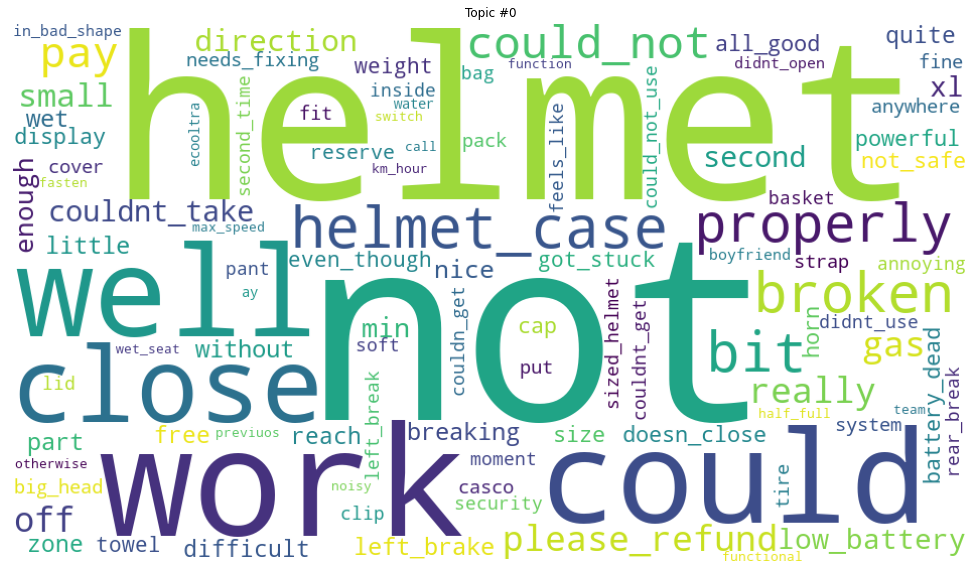

<Figure size 432x288 with 0 Axes>

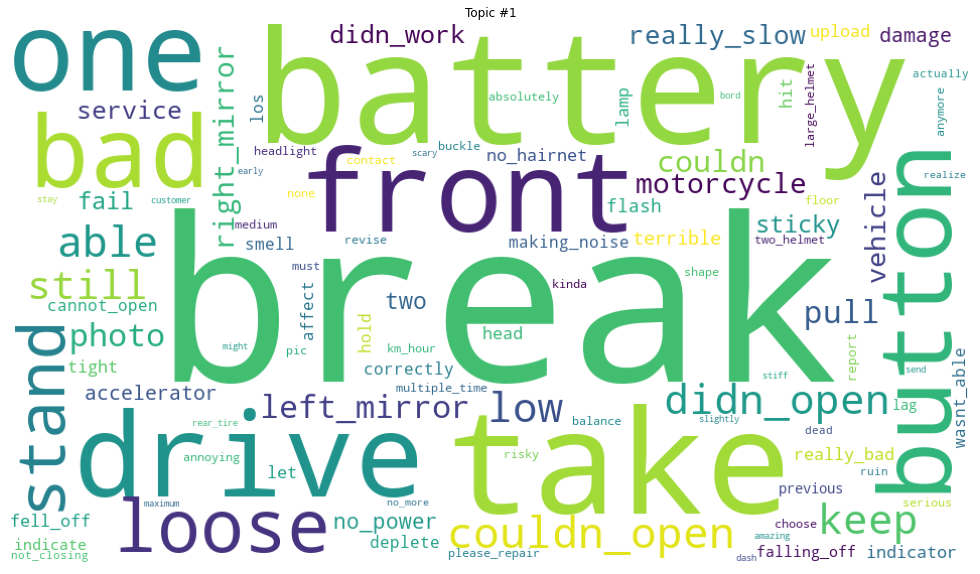

<Figure size 432x288 with 0 Axes>

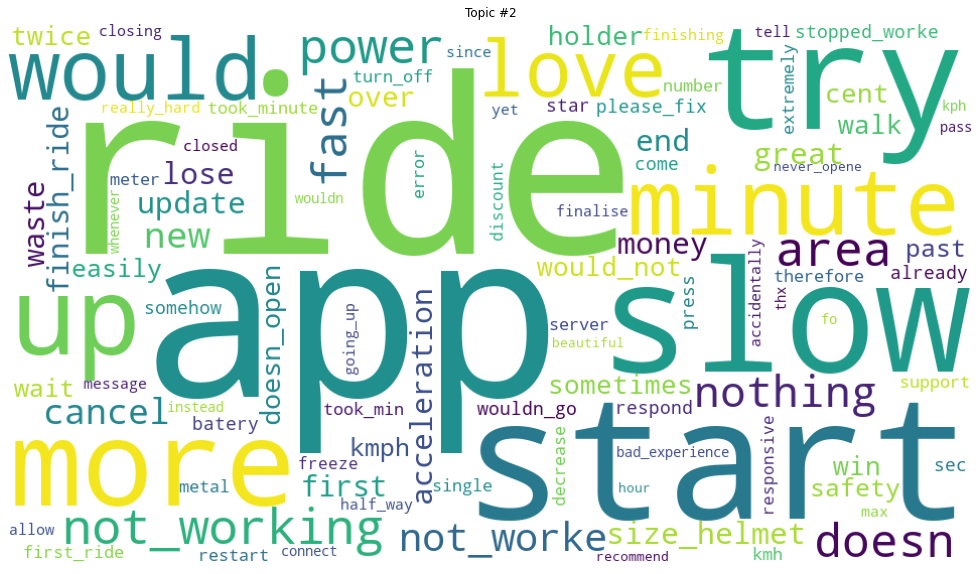

<Figure size 432x288 with 0 Axes>

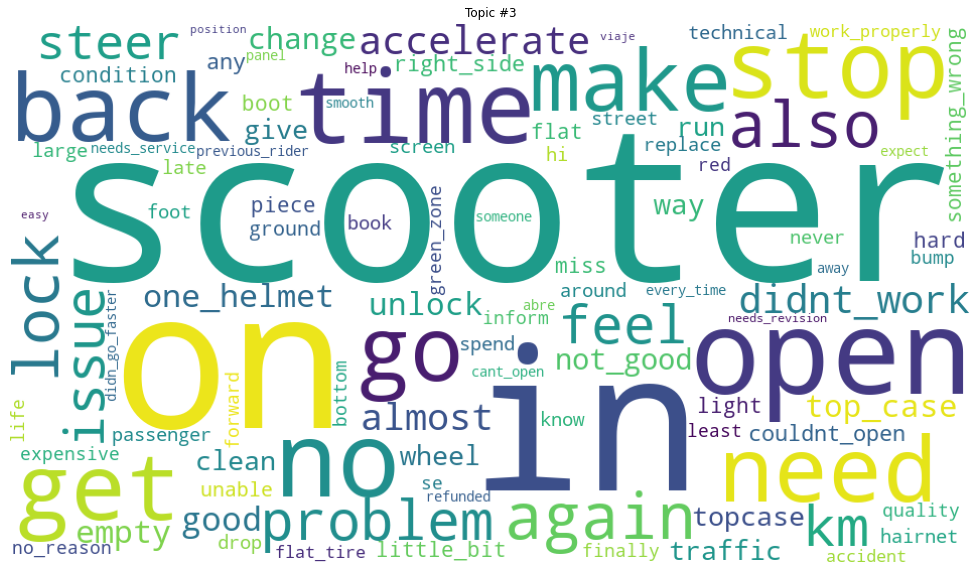

<Figure size 432x288 with 0 Axes>

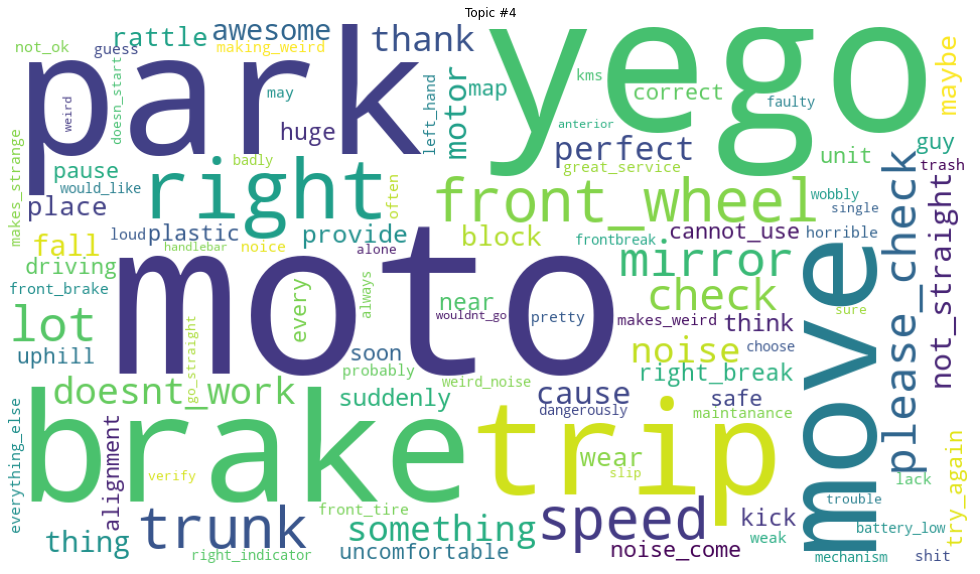

<Figure size 432x288 with 0 Axes>

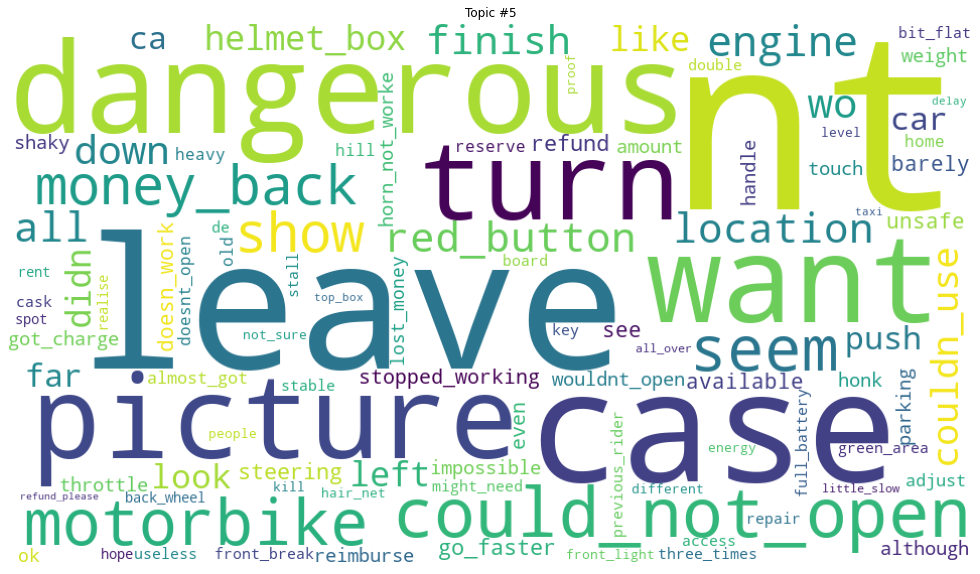

<Figure size 432x288 with 0 Axes>

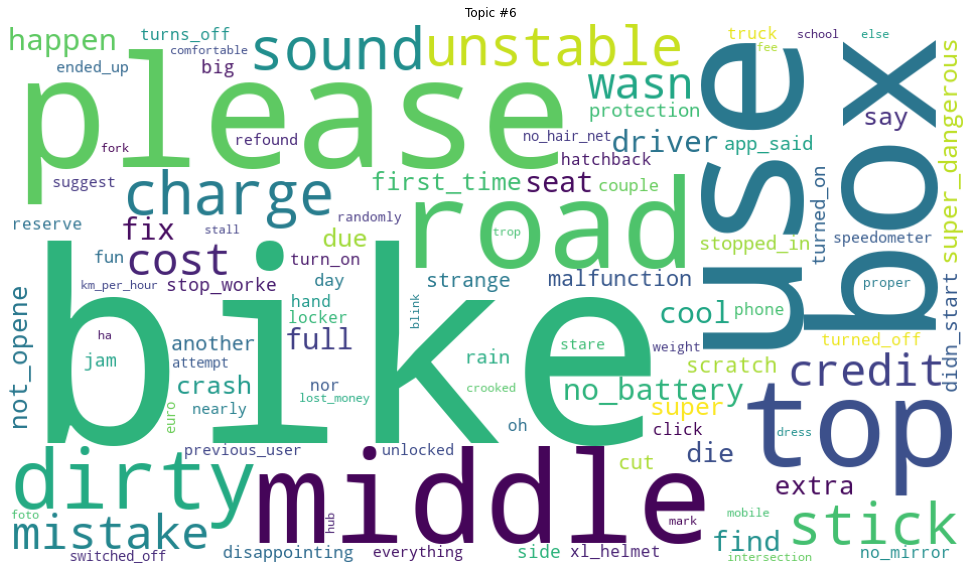

<Figure size 432x288 with 0 Axes>

In [460]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

for t in range(lda_model.num_topics):
    plt.figure(figsize=(20,10))
    plt.imshow(WordCloud(background_color="white", max_words=100, width=960,height=540).fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()
    plt.savefig(f'topic_{t}.png')



### 3.2 t-SNE plot

This shows the topics in 2 dimensions so we can see the similarity between topics. Over your mouse over each point to see some example reviews for that point. 

In [461]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# # Plot the Topic Clusters using Bokeh
# output_notebook()
# n_topics = 7
# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
# plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
#               plot_width=900, plot_height=700)
# plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
# show(plot)



df['topic'] = topic_num
df['topic']

from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()
top_labels = {0: 'Topic 0', 1:'Topic 1', 2:'Topic 2', 3:'Topic 3', 4: 'Topic 4', 5: 'Topic 5', 6: 'Topic 6'}
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange'}

df['colors'] = df['topic'].apply(lambda l: cluster_colors[l])
source = ColumnDataSource(dict(
    x=tsne_lda[:,0],
    y=tsne_lda[:,1],
    color=df['colors'],
    label=df['topic'].apply(lambda l: top_labels[l]),
#     msize= p_df['marker_size'],
    topic_key= topic_num,
    #title= p_df[u'Title'],
    content = df['feedback_message']
))


title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600, title=title, tools="pan,wheel_zoom,box_zoom,reset,hover", x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8, size=10)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - Topic: @topic_key "}
plot_lda.legend.location = "top_left"

show(plot_lda)

#save the plot
# save(plot_lda, '{}.html'.format(title))


# import seaborn as sb
# output_notebook()
# #plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
# plt.figure(figsize=(16, 9))
# sb.scatterplot(
#     tsne_lda[:,0], y=tsne_lda[:,1], hue=topic_num, 
#     legend="full", palette="rainbow"
# )

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12414 samples in 0.031s...
[t-SNE] Computed neighbors for 12414 samples in 1.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12414
[t-SNE] Computed conditional probabilities for sample 2000 / 12414
[t-SNE] Computed conditional probabilities for sample 3000 / 12414
[t-SNE] Computed conditional probabilities for sample 4000 / 12414
[t-SNE] Computed conditional probabilities for sample 5000 / 12414
[t-SNE] Computed conditional probabilities for sample 6000 / 12414
[t-SNE] Computed conditional probabilities for sample 7000 / 12414
[t-SNE] Computed conditional probabilities for sample 8000 / 12414
[t-SNE] Computed conditional probabilities for sample 9000 / 12414
[t-SNE] Computed conditional probabilities for sample 10000 / 12414
[t-SNE] Computed conditional probabilities for sample 11000 / 12414
[t-SNE] Computed conditional probabilities for sample 12000 / 12414
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

### 3.3 pyLDAvis plot

This plot again shows the topics plotted in 2 dimensions. The distance between the topics is a measure of their similarity. If the topics are further away, the topics are less similar. Hover your mouse over each topic to see what the most important words are in that topic. You can also use the "Next Topic" button to look at each topic, since some topics are close together and it's difficult to pin point them with the mouse. 

**Important** to note here that the topic numbers do not correspond with the topic numbers in the rest of the report. This is a weakness of pyLDAvis. You can decode the topics as the following:

pyLDAvis Topic = Original topic number (from above) <br>
Topic 1 = Topic 3 <br>
Topic 2 = Topic 0 <br>
Topic 3 = Topic 2 <br>
Topic 4 = Topic 1 <br>
Topic 5 = Topic 4 <br>
Topic 6 = Topic 5 <br>
Topic 7 = Topic 6 <br>



In [462]:
import  pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.414096  0.015578       1        1  23.621841
0     -0.087688  0.380000       2        1  14.995683
2     -0.067201 -0.120721       3        1  14.080659
1     -0.065318 -0.107943       4        1  12.596881
4     -0.071990 -0.130170       5        1  12.242651
5     -0.058972  0.006138       6        1  11.265866
6     -0.062928 -0.042882       7        1  11.196419, topic_info=                 Term         Freq        Total Category  logprob  loglift
7                 not  1794.000000  1794.000000  Default  30.0000  30.0000
147            helmet  1312.000000  1312.000000  Default  29.0000  29.0000
111              bike   916.000000   916.000000  Default  28.0000  28.0000
86            scooter  1231.000000  1231.000000  Default  27.0000  27.0000
143                nt   782.000000   782.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
207         not_opene    71.686478    72.529589   Topic7  -4.6307   2.1779
425               say    68.864713    69.706639   Topic7  -4.6708   2.1774
76              super    65.056993    65.900759   Topic7  -4.7277   2.1767
2301  super_dangerous    65.663243    66.516153   Topic7  -4.7184   2.1767
824        first_time    67.182955    74.844207   Topic7  -4.6955   2.0816

[245 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
429       4  0.993913          able
400       1  0.996528    accelerate
250       3  0.991786  acceleration
93        1  0.997628         again
500       6  0.991625           all
...     ...       ...           ...
1728      6  0.992887            wo
5         2  0.999234          work
37        3  0.996036         would
681       2  0.990545            xl
2180      5  0.998573          yego

[223 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5, 6, 7])

### 3.4 Plot of changing topic proportions over time.

This plots shows how the volume of each topic changes over time.

<AxesSubplot:xlabel='year'>

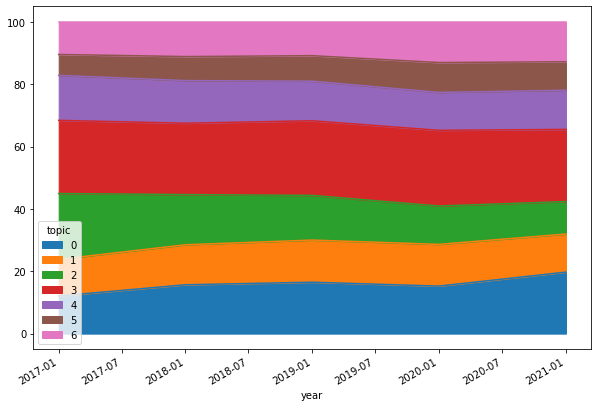

In [463]:
df_ts = df.groupby(['year','topic'], as_index=True).count()
df_ts1 = df_ts[['Date']]
df_ts2 = df_ts1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
df_ts3 = df_ts2.pivot_table(index=["year"], 
                    columns='topic', 
                    values='Date')
df_ts3.index= pd.to_datetime(df_ts3.index,format='%Y')
df_ts3.plot.area(figsize=(10,7), use_index=True,x_compat=True)

## 4. Classifying new reviews into the topics.

This next section uses the model we created and inputs new reviews and then gives these reviews one of the 7 topics that we created. I used two mock reviews that I created to show which topic they are assigned to. 

You can import new data, call it new_df and have the reviews take the column name "feedback_message" and substitute this importing of data into the following chunk. The next chunk (aka cell) created fake data. It can be substituted with real data.

In [464]:
#CREATION OF FAKE DATA HERE
new_df=pd.DataFrame({'feedback_message':[
    'scooter, in, on, open, no, time, stop, get, back, need', # review 1
    'bike use box please middle top road' #review 2
]})


### 4.1 The following table assigns  each new review to a topic

The table shows that the first mock review is assigned to the topic 0, looking at the "Dominant_Topic" column. The second review is assigned to topic 2.

In [465]:
# Convert to list
data = new_df.feedback_message.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:3])
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# !python3 -m spacy download en  # run in terminal once
data_ready = process_words(data_words)  # processed Text Data!
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

[['scooter', 'in', 'on', 'open', 'no', 'time', 'stop', 'get', 'back', 'need'], ['bike', 'use', 'box', 'please', 'middle', 'top', 'road']]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4149,"not, helmet, work, could, well, close, helmet_case, bit, broken, properly","[scooter, in, on, open, no, time, stop, get, back, need]"
1,1,2.0,0.5180,"ride, app, start, slow, try, more, up, minute, would, love","[bike, use, box, please, middle, top, road]"
